Test whether the model works.

In [1]:
#@title imports

import os
import time
import numpy as np
from ipywidgets import FloatProgress

from cs285.infrastructure.rl_trainer import RL_Trainer
from cs285.agents.bc_agent import BCAgent
from cs285.policies.loaded_gaussian_policy import LoadedGaussianPolicy
from cs285.infrastructure.utils import MJ_ENV_KWARGS, MJ_ENV_NAMES

%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\DeadScholar\Miniconda3\envs\cs285\lib\site-packages\IPython\extensions\autoreload.py:121: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
#@title runtime arguments

class Args:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cs285/policies/experts/Ant.pkl' #@param
  expert_data = 'cs285/expert_data/expert_data_Ant-v4.pkl' #@param
  env_name = 'Ant-v4' #@param ['Ant-v4', 'Walker2d-v4', 'HalfCheetah-v4', 'Hopper-v4']
  exp_name = 'bc_ant' #@param
  do_dagger = False #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 1 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 1000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = 5 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}

args = Args()


In [3]:
#@title define `BC_Trainer`
class BC_Trainer(object):

    def __init__(self, params):
        #######################
        ## AGENT PARAMS
        #######################

        agent_params = {
            'n_layers': params['n_layers'],
            'size': params['size'],
            'learning_rate': params['learning_rate'],
            'max_replay_buffer_size': params['max_replay_buffer_size'],
            }

        self.params = params
        self.params['agent_class'] = BCAgent ## TODO: look in here and implement this
        self.params['agent_params'] = agent_params

        self.params["env_kwargs"] = MJ_ENV_KWARGS[self.params['env_name']]

        ################
        ## RL TRAINER
        ################

        self.rl_trainer = RL_Trainer(self.params) ## TODO: look in here and implement this

        #######################
        ## LOAD EXPERT POLICY
        #######################

        print('Loading expert policy from...', self.params['expert_policy_file'])
        self.loaded_expert_policy = LoadedGaussianPolicy(self.params['expert_policy_file'])
        print('Done restoring expert policy...')

    def run_training_loop(self):

        self.rl_trainer.run_training_loop(
            n_iter=self.params['n_iter'],
            initial_expertdata=self.params['expert_data'],
            collect_policy=self.rl_trainer.agent.actor,
            eval_policy=self.rl_trainer.agent.actor,
            relabel_with_expert=self.params['do_dagger'],
            expert_policy=self.loaded_expert_policy,
        )


In [4]:
#@title create directory for logging

if args.do_dagger:
    logdir_prefix = 'q2_'  # The autograder uses the prefix `q2_`
    assert args.n_iter>1, ('DAgger needs more than 1 iteration (n_iter>1) of training, to iteratively query the expert and train (after 1st warmstarting from behavior cloning).')
else:
    logdir_prefix = 'q1_'  # The autograder uses the prefix `q1_`
    assert args.n_iter==1, ('Vanilla behavior cloning collects expert data just once (n_iter=1)')

data_path ='/content/cs285_f2022/hw1/data'
if not (os.path.exists(data_path)):
    os.makedirs(data_path)
logdir = logdir_prefix + args.exp_name + '_' + args.env_name + \
         '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join(data_path, logdir)
args['logdir'] = logdir
if not(os.path.exists(logdir)):
    os.makedirs(logdir)

In [5]:
## run training
print(args.logdir)
# trainer = BC_Trainer(args)
# trainer.run_training_loop()

/content/cs285_f2022/hw1/data\q1_bc_ant_Ant-v4_10-09-2022_14-31-11


In [11]:
from cs285.infrastructure import pytorch_util
from importlib import reload
reload(pytorch_util)

<module 'cs285.infrastructure.pytorch_util' from 'c:\\users\\deadscholar\\programming\\cs 285 fall 2022\\cs-285_fall2022\\hw1\\cs285\\infrastructure\\pytorch_util.py'>

8
Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=3, bias=True)
  (7): ReLU()
)


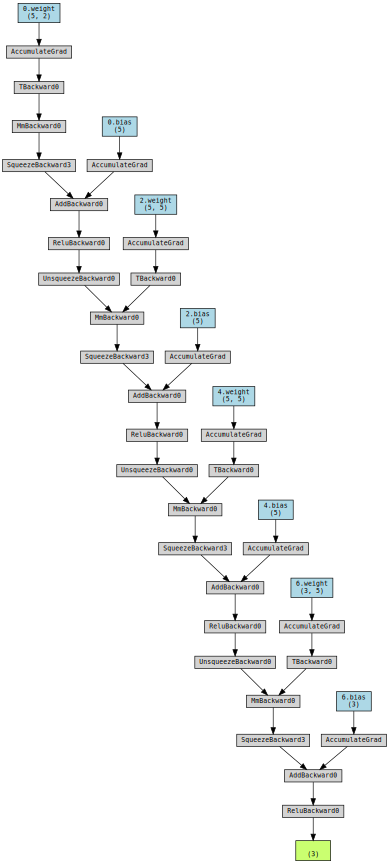

In [13]:
test_mlp = pytorch_util.build_mlp(input_size=2, output_size=3, n_layers=3, size=5, activation='relu', output_activation='relu')
print(test_mlp)

from torchviz import make_dot
import torch

x = torch.randn(2)
yhat = test_mlp(x)
make_dot(yhat, params=dict(list(test_mlp.named_parameters())))

Playing with [Gym Documentation](https://www.gymlibrary.dev/)

In [4]:
import gym
env = gym.make("LunarLander-v2")
env.action_space.seed(42)

observation = env.reset(seed=42)


for _ in range(100):
    observation, reward, terminated, truncated = env.step(env.action_space.sample())
    # ipdb.set_trace()
    if terminated or truncated:
        observation = env.reset()

env.close()


> c:\users\deadscholar\appdata\local\temp\ipykernel_27208\2506726945.py(11)<module>()



ipdb>  reward


1.1449803922348565


ipdb>  observation


array([ 0.00459394,  1.424763  ,  0.23233262,  0.2947628 , -0.00525882,
       -0.05208295,  0.        ,  0.        ], dtype=float32)


ipdb>  type(observation)


<class 'numpy.ndarray'>


ipdb>  q


BdbQuit: 

> c:\users\deadscholar\miniconda3\envs\cs285\lib\bdb.py(113)dispatch_line()
    111         if self.stop_here(frame) or self.break_here(frame):
    112             self.user_line(frame)
--> 113             if self.quitting: raise BdbQuit
    114         return self.trace_dispatch
    115 



ipdb>  q


In [3]:
env = gym.make("LunarLander-v2")
env.action_space.seed(42)

observation = env.reset(seed=42)
env.step(env.action_space.sample())

(array([ 0.00459394,  1.424763  ,  0.23233262,  0.2947628 , -0.00525882,
        -0.05208295,  0.        ,  0.        ], dtype=float32),
 1.1449803922348565,
 False,
 {})

In [7]:
import logging
import ipdb
%pdb on
from importlib import reload

import cs285.infrastructure.utils as utils
reload(utils)



Automatic pdb calling has been turned ON


<module 'cs285.infrastructure.utils' from 'c:\\users\\deadscholar\\programming\\cs 285 fall 2022\\cs-285_fall2022\\hw1\\cs285\\infrastructure\\utils.py'>

In [10]:
temp_env = gym.make("LunarLander-v2") 
max_path_length = 10
env.action_space.seed(42)
observation = env.reset(seed=42)
def rand_policy(obs):
    return env.action_space.sample()
utils.sample_trajectory(temp_env, rand_policy, max_path_length, render=False)

AttributeError: 'function' object has no attribute 'get_action'

> c:\users\deadscholar\programming\cs 285 fall 2022\cs-285_fall2022\hw1\cs285\infrastructure\utils.py(30)sample_trajectory()
     28         # use the most recent ob to decide what to do
     29         obs.append(ob) # DOING
---> 30         ac = policy.get_action(ob) # `obs` is a list. We want a `numpy.ndarry`.
     31         print("lol ", ac)
     32         ac = ac[0] # what is this doing??



ipdb>  ob


array([ 0.00654459,  1.4080483 ,  0.66288275, -0.12765771, -0.00757677,
       -0.15015279,  0.        ,  0.        ], dtype=float32)


ipdb>  get_action


*** NameError: name 'get_action' is not defined


ipdb>  q
